# CausalML Uplift Tree Visualization

In [ ]:
# Code from https://github.com/uber/causalml/tree/master/examples

## Introduction
This example notebooks illustrates how to visualize uplift trees for interpretation and diagnosis. 

#### Supported Models
These visualization functions work only for tree-based algorithms:

- Uplift tree/random forests on KL divergence, Euclidean Distance, and Chi-Square
- Uplift tree/random forests on Contextual Treatment Selection

Currently, they are NOT supporting Meta-learner algorithms

- S-learner
- T-learner
- X-learner
- R-learner

#### Supported Usage
This notebook will show how to use visualization for:

- Uplift Tree and Uplift Random Forest
    - Visualize a trained uplift classification tree model
    - Visualize an uplift tree in a trained uplift random forests

- Training and Validation Data
    - Visualize the validation tree: fill the trained uplift classification tree with validation (or testing) data, and show the statistics for both training data and validation data
    
- One Treatment Group and Multiple Treatment Groups
    - Visualize the case where there are one control group and one treatment group
    - Visualize the case where there are one control group and multiple treatment groups



## Step 1 Load Modules

### Load CausalML modules

In [13]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

### Load standard modules

In [14]:
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split

## One Control + One Treatment for Uplift Classification Tree 

In [15]:
# Data generation
df, x_names = make_uplift_classification()

# Rename features for easy interpretation of visualization
x_names_new = ['feature_%s'%(i) for i in range(len(x_names))]
rename_dict = {x_names[i]:x_names_new[i] for i in range(len(x_names))}
df = df.rename(columns=rename_dict)
x_names = x_names_new

df.head()

df = df[df['treatment_group_key'].isin(['control','treatment1'])]

# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.5110,1000
treatment1,0.5140,1000
All,0.5125,2000


In [16]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [17]:
# Print uplift tree as a string
result = uplift_tree_string(uplift_model.fitted_uplift_tree, x_names)

feature_17 >= -0.44234212654232735?
yes -> feature_10 >= 1.020659213325515?
		yes -> {'treatment1': 0.606557, 'control': 0.381356}
		no  -> {'treatment1': 0.526786, 'control': 0.507812}
no  -> feature_9 >= 0.8142773340486678?
		yes -> {'treatment1': 0.61, 'control': 0.459677}
		no  -> feature_4 >= 0.280545459525536?
				yes -> {'treatment1': 0.41433, 'control': 0.552288}
				no  -> {'treatment1': 0.574803, 'control': 0.507042}


#### Read the tree
- First line: node split condition
- impurity: the value for the loss function
- total_sample: total sample size in this node
- group_sample: sample size by treatment group
- uplift score: the treatment effect between treatment and control (when there are multiple treatment groups, this is the maximum of the treatment effects)
- uplift p_value: the p_value for the treatment effect
- validation uplift score: when validation data is filled in the tree, this reflects the uplift score based on the - validation data. It can be compared with the uplift score (for training data) to check if there are over-fitting issue.

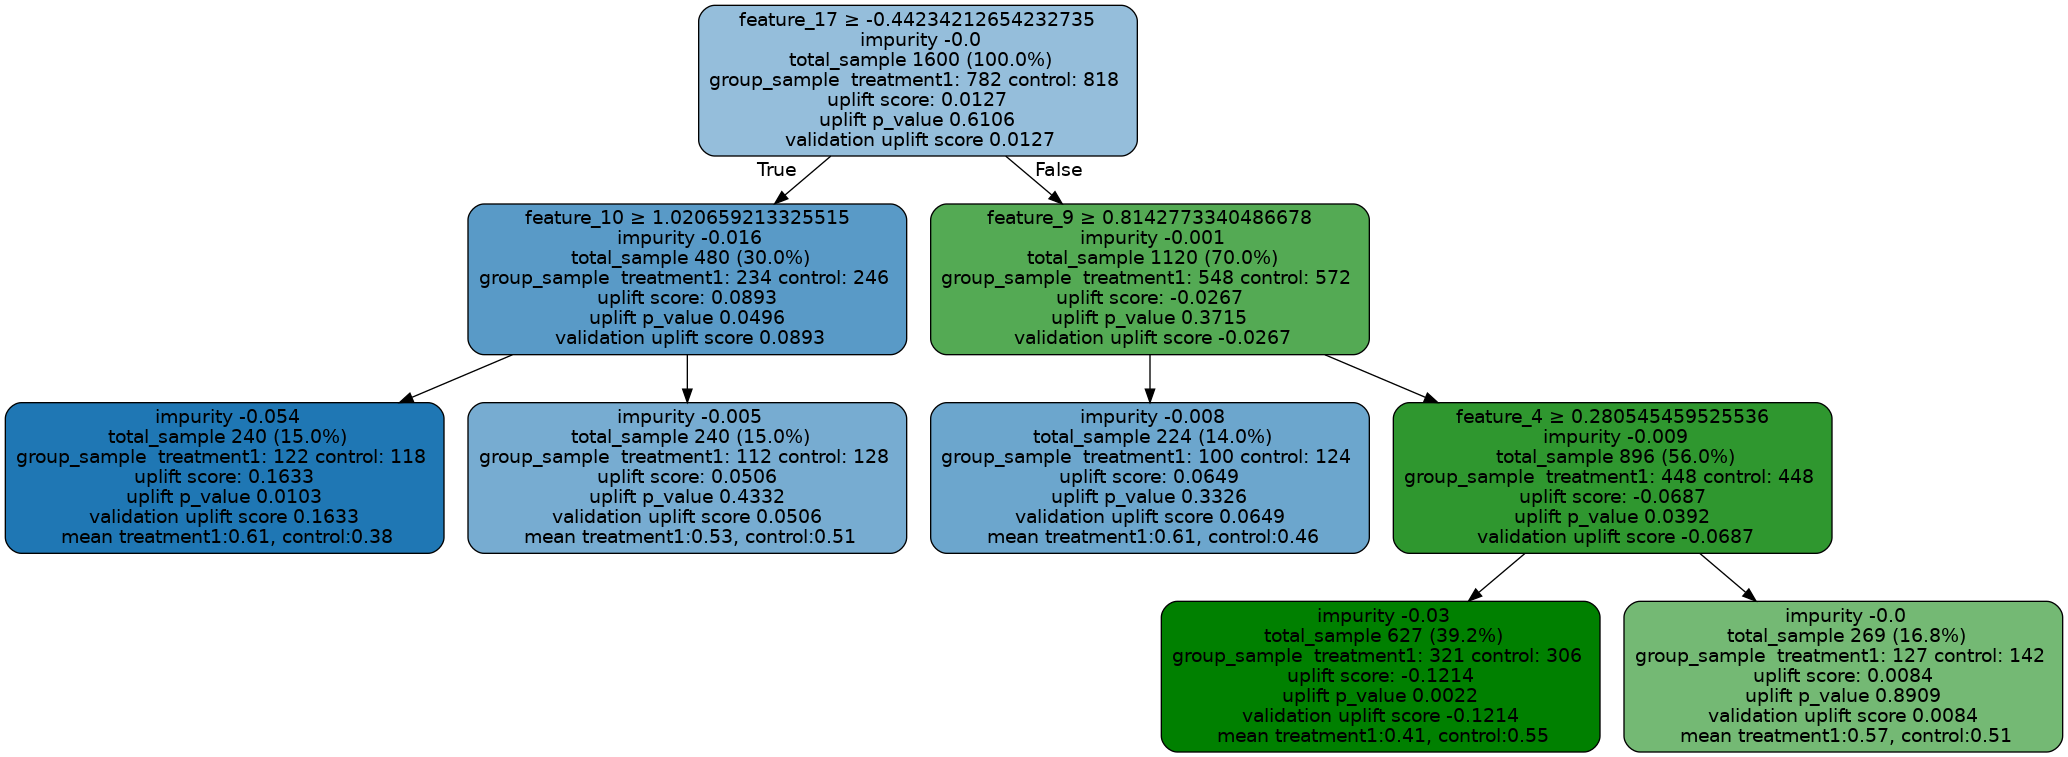

In [18]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

### Visualize Validation Tree: One Control + One Treatment for Uplift Classification Tree
Note the validation uplift score will update.

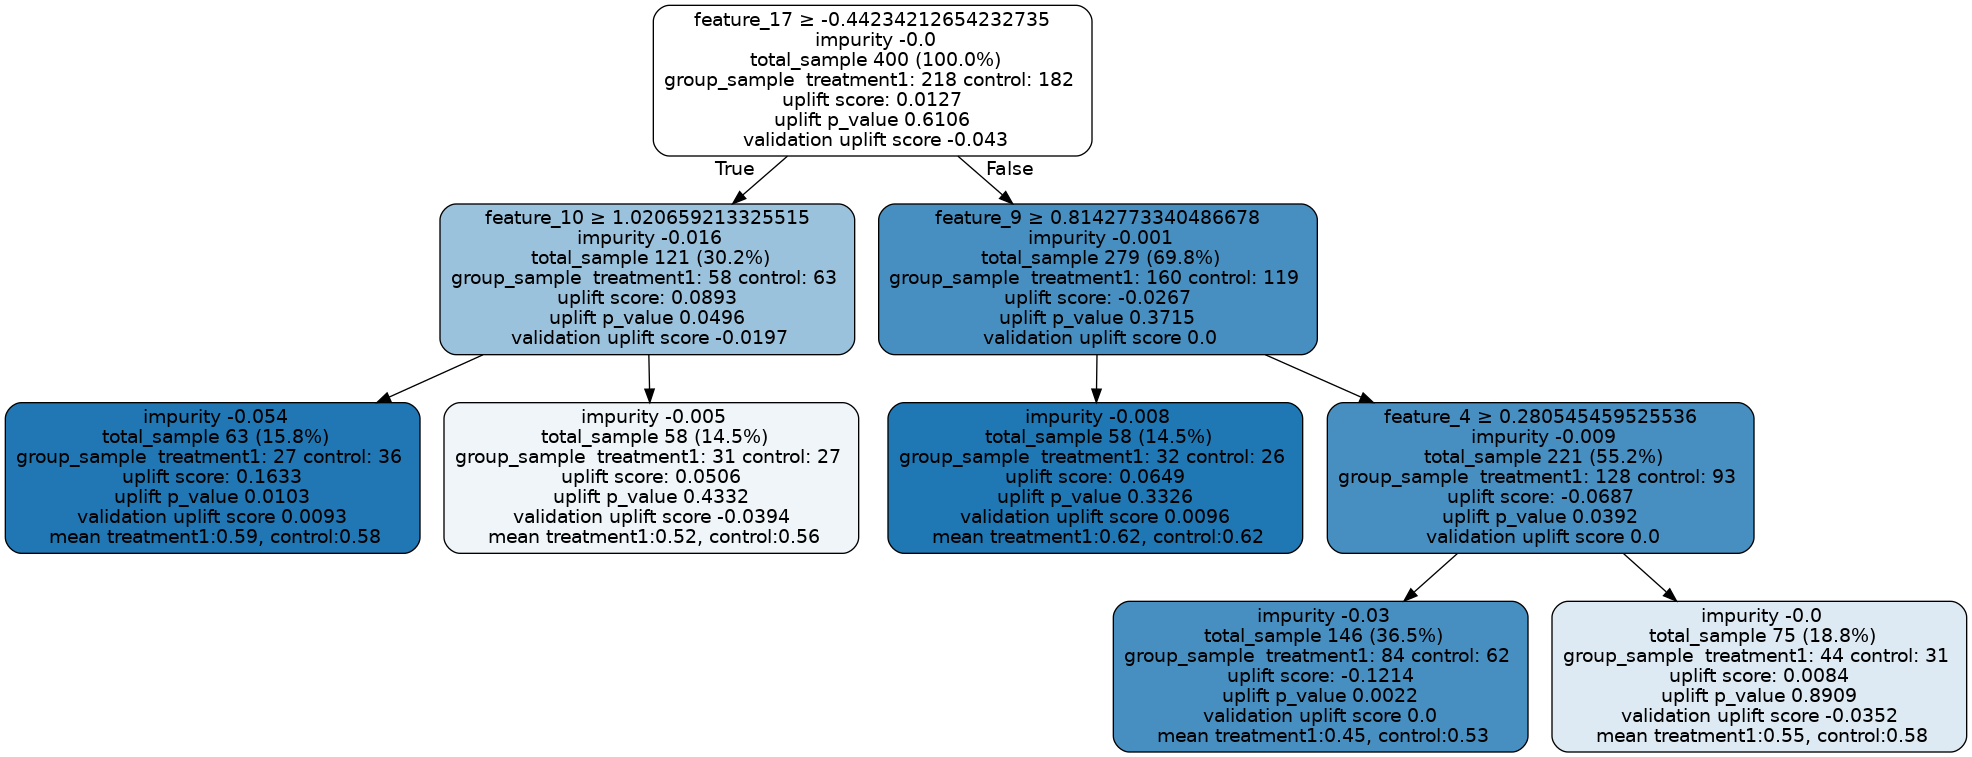

In [19]:
### Fill the trained tree with testing data set 
# The uplift score based on testing dataset is shown as validation uplift score in the tree nodes
uplift_model.fill(X=df_test[x_names].values, treatment=df_test['treatment_group_key'].values, y=df_test['conversion'].values)

# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

### Visualize a Tree in Random Forest

In [20]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftRandomForestClassifier(n_estimators=5, max_depth = 5, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [21]:
# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_model.uplift_forest[0]
# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, x_names)

feature_9 >= 0.7626607142400706?
yes -> {'treatment1': 0.621795, 'control': 0.481707}
no  -> feature_12 >= 0.5486596851987631?
		yes -> feature_4 >= 0.9956888137470166?
				yes -> {'treatment1': 0.496815, 'control': 0.398773}
				no  -> {'treatment1': 0.483871, 'control': 0.551515}
		no  -> feature_9 >= -0.15675867904794422?
				yes -> {'treatment1': 0.456376, 'control': 0.48538}
				no  -> {'treatment1': 0.40625, 'control': 0.625}


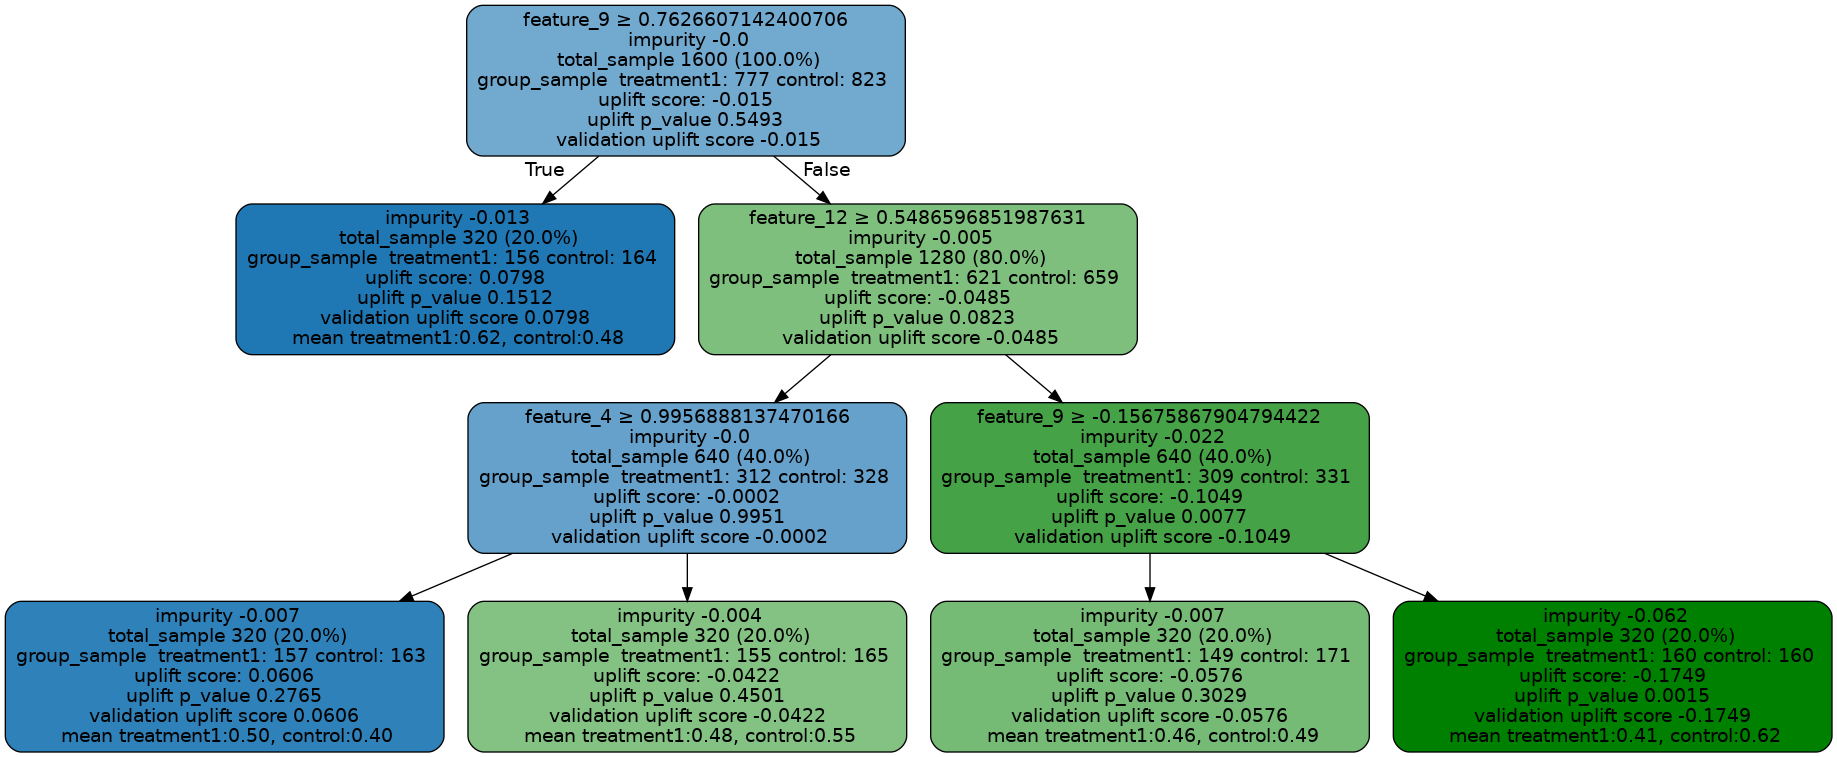

In [22]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())

#### Fill the tree with validation data

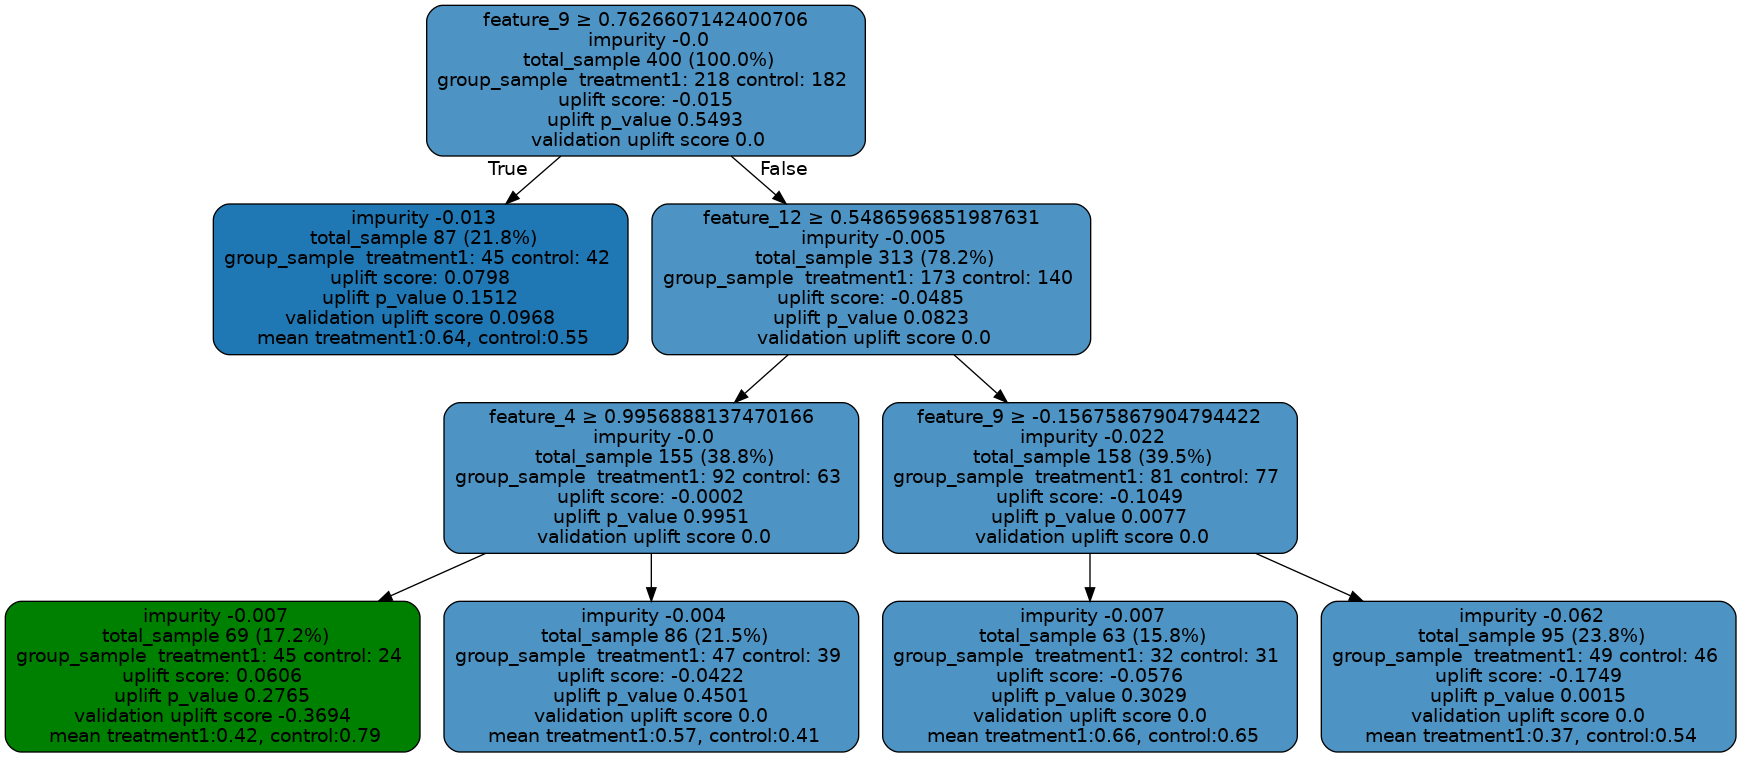

In [23]:
### Fill the trained tree with testing data set 
# The uplift score based on testing dataset is shown as validation uplift score in the tree nodes
uplift_tree.fill(X=df_test[x_names].values, treatment=df_test['treatment_group_key'].values, y=df_test['conversion'].values)

# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())

## One Control + Multiple Treatments

In [24]:
# Data generation
df, x_names = make_uplift_classification()
# Look at the conversion rate and sample size in each group
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.511,1000
treatment1,0.514,1000
treatment2,0.559,1000
treatment3,0.600,1000
All,0.546,4000


In [25]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftTreeClassifier(max_depth = 3, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

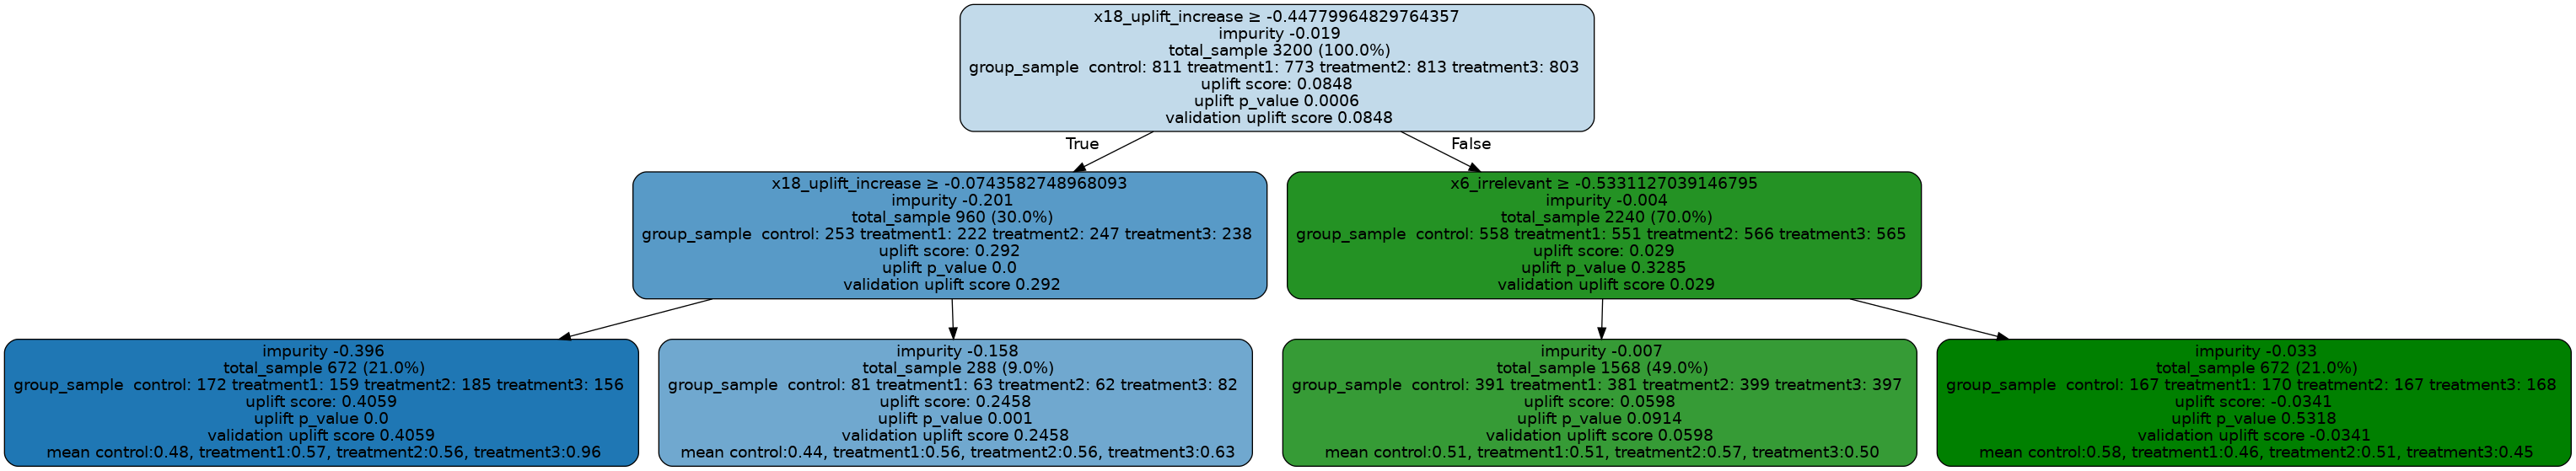

In [26]:
# Plot uplift tree
# The uplift score represents the best uplift score among all treatment effects
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

### Save the Plot

In [27]:
# Save the graph as pdf
graph.write_pdf("tbc.pdf")
# Save the graph as png
graph.write_png("tbc.png")

True